In [1]:
import pandas as pd

# Read ITC data from CSV using pandas
df = pd.read_csv("Dataset/ITC_minute.csv")

# Convert 'date' column to datetime and sort
df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y %H:%M")
df = df.sort_values('date').reset_index(drop=True)

print("Data Loaded with Pandas")
print(df.head())
print(df.info())


Data Loaded with Pandas
                 date    open    high     low   close  volume
0 2015-02-02 09:15:00  211.60  212.75  211.55  212.25  152000
1 2015-02-02 09:16:00  212.20  212.30  211.45  211.75   76319
2 2015-02-02 09:17:00  211.85  212.25  211.80  212.15   42411
3 2015-02-02 09:18:00  212.10  212.15  212.05  212.15   44466
4 2015-02-02 09:19:00  212.15  212.50  212.15  212.50   90079
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972555 entries, 0 to 972554
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    972555 non-null  datetime64[ns]
 1   open    972555 non-null  float64       
 2   high    972555 non-null  float64       
 3   low     972555 non-null  float64       
 4   close   972555 non-null  float64       
 5   volume  972555 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 44.5 MB
None


In [2]:
# Block merged into Block 1 (handled with pandas datetime conversion)


In [3]:
pdf = df[["date", "close"]]
pdf.set_index("date", inplace=True)

print("Done")


Done


In [4]:
# Normalising Data

from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pdf[['close']])

print("done")


done


In [5]:
# 60 timestamps -> next close (ie) 1 min interval
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Reshape for model: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("Done")


Done


In [6]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Done, Ready for Training and Test")


Done, Ready for Training and Test


In [7]:
# TCN (Temporal Convolutional Network)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tcn import TCN

model = Sequential([
    TCN(
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8],
        nb_stacks=3,
        dropout_rate=0.2,
        return_sequences=False,
        input_shape=(X_train.shape[1], 1)
    ),
    Dense(25),
    Dense(1)
])

# Compile and summarize 
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



2025-10-15 21:51:02.370742: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 21:51:02.432584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 21:51:03.791302: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/dhinesh-fedor/.local/lib/python3.13/site-packages/tcn/tcn.py:268: UserWarn

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       284,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,131 (1.09 MB)

 Trainable params: 286,131 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Training

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20, batch_size=64)


Epoch 1/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 1400s 115ms/step - loss: 10.2893 - val_loss: 8.0759e-06
Epoch 2/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 1324s 109ms/step - loss: 6.4575e-04 - val_loss: 9.3511e-06
Epoch 3/20
12156/12157 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2.4270e-05

KeyboardInterrupt: 

In [9]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))


6079/6079 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step


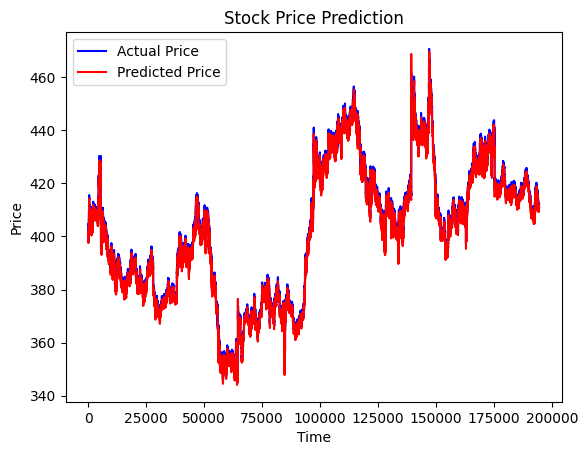

In [10]:
import matplotlib.pyplot as plt

plt.plot(y_test_real, color='blue', label='Actual Price')
plt.plot(predictions, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [11]:
# Model Save

# Save the full model (architecture + weights + optimizer state)
model.save('itc_tcn_normal.keras')

import pickle

with open('scaler_tcn_normal.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("done")


done


In [12]:
from tcn import TCN
from tensorflow.keras.models import load_model
import pickle
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries

# ---------------------------
# Load Alpha Vantage Data
# ---------------------------
api_key = "R9SUJLHNB1HWPE3W"
symbol = "ITC.BSE"

ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol=symbol, outputsize="full")  # full historical data
data = data[['4. close']]
data.rename(columns={'4. close': 'Close'}, inplace=True)

# Convert index to datetime and reverse to chronological order
data = data[::-1].reset_index()
data['date'] = pd.to_datetime(data['date'])

# Filter for September 2025
august_data = data[(data['date'].dt.year == 2025) & (data['date'].dt.month == 10)].reset_index(drop=True)
print("October 2025 Data:\n", august_data)

# ---------------------------
# Load Model and Scaler
# ---------------------------
model = load_model("itc_tcn_normal.keras", custom_objects={'TCN': TCN})
with open("scaler_tcn_normal.pkl", "rb") as f:
    scaler = pickle.load(f)

# ---------------------------
# Prepare Last 60 Close Prices
# ---------------------------
last_60_prices = august_data['Close'].values[-60:]
last_60_prices_df = pd.DataFrame(last_60_prices, columns=['close'])

# Scale and reshape
scaled_prices = scaler.transform(last_60_prices_df)
X_live = scaled_prices.reshape(1, len(last_60_prices), 1)  # TCN input shape

# ---------------------------
# Predict Trend
# ---------------------------
predicted_value = model.predict(X_live)
trend = "Bullish" if predicted_value > 0.5 else "Bearish"
print("Tomorrow's Predicted Trend:", trend)
print("Raw Model Output:", predicted_value[0][0])


October 2025 Data:
         date   Close
0 2025-10-01  405.65
1 2025-10-03  404.35
2 2025-10-06  400.80
3 2025-10-07  399.85
4 2025-10-08  399.70
5 2025-10-09  399.90
6 2025-10-10  402.80
7 2025-10-13  399.10
8 2025-10-14  396.70
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Tomorrow's Predicted Trend: Bullish
Raw Model Output: 0.82634425
